In [1]:
# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from numpy import trapz
from scipy.stats import norm
from sklearn.cluster import KMeans
import sys
from pathlib import Path
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))


In [5]:
# Configuration
config = {
    'casr_input_data': project_root / 'data' / 'output_data' / 'merged_2d' / '1980_2024'/'bow_combined_full_data.csv',
    'shapefile': project_root / 'data' / 'input_data' / 'shapefiles'/'BowRiverBasin'/'Bow_elevation_combined.shp',
    'canswe_original_data' : project_root / 'data' / 'output_data' / 'for_paper'/'FROSTBITE' / 'bow_canswe.nc',
    'gap_filled_canswe_data' : project_root / 'data' / 'output_data' / 'for_paper'/'FROSTBITE' /'bow_swe_gapfilled_data_only.nc',
    'SWEI_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SWEI',
    'classification_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SD_classification',
    'SPI_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SPI',
    'SPEI_output_dir': project_root / 'data' / 'output_data' / 'for_paper'/'SPEI',
    'SWEI_plots': project_root / 'data' / 'output_plots' / 'for_paper'/'SWEI',
    'classification_plots': project_root / 'data' / 'output_plots'/'for_paper'/'SD_classification',
    'SPI_plots': project_root / 'data' / 'output_plots' / 'for_paper'/'SPI',
    'SPEI_plots': project_root / 'data' / 'output_plots' /'for_paper'/'SPEI',
}

In [6]:
# Load data data
CaSR_data = pd.read_csv(config['casr_input_data'])

# Load shapefile for Bow Basin
bow_basin = gpd.read_file(config['shapefile'])

# Load original CanSWE data
canswe_data = xr.open_dataset(config['canswe_original_data'])

# Load gap-filled CanSWE data
gap_filled_canswe_data = xr.open_dataset(config['gap_filled_canswe_data'])

# CaSR dataframe
bow_data = CaSR_data[['time', 'Grid_id','lon', 'lat', 'SWE', 'Precipitation', 'Elevation_Category']].copy()
bow_data['time'] = pd.to_datetime(bow_data['time'])

display(bow_data.head())

#Original CanSWE dataframe
canswe_df = canswe_data.to_dataframe().reset_index()
canswe_df['time'] = pd.to_datetime(canswe_df['time'])
display(canswe_df.head())

#Gap-filled CanSWE dataframe
gap_filled_canswe_df = gap_filled_canswe_data.to_dataframe().reset_index()
gap_filled_canswe_df['time'] = pd.to_datetime(gap_filled_canswe_df['time'])
display(gap_filled_canswe_df.head())


,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category
0,1980-10-10,1,-116.1380,51.3346,0.878418,0.009879,2000_2500m
1,1982-07-19,1,-116.1380,51.3346,0.515625,2.765854,2000_2500m
2,1983-10-12,2,-116.1875,51.4191,6.875000,0.023846,2000_2500m
3,1980-12-11,2,-116.1875,51.4191,118.125000,4.578907,2000_2500m
4,1981-07-21,2,-116.1875,51.4191,0.000000,5.400473,2000_2500m


,station_id,time,lat,lon,elevation,source,station_name,station_name_sec,station_name_ter,station_id_sec,station_id_ter,type_mes,snw,snd,den,data_flag_snw,data_flag_snd,qc_flag_snw,qc_flag_snd
0,ALE-05BA811,1928-01-01,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
1,ALE-05BA811,1928-01-02,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
2,ALE-05BA811,1928-01-03,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
3,ALE-05BA811,1928-01-04,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''
4,ALE-05BA811,1928-01-05,51.700001,-116.466667,2080.0,Alberta Environment,BOW SUMMIT (OLD),None,None,None,None,0,NaN,NaN,NaN,b'',b'',b'',b''


,time,station_id,lat,lon,station_name,SWE
0,1980-01-01,ALE-05BA811,51.700001,-116.466667,BOW SUMMIT (OLD),NaN
1,1980-01-01,ALE-05BL801,50.599998,-114.983330,HIGHWOOD S. OPEN,NaN
2,1980-01-01,ALE-05BL808,50.483334,-114.866669,MOUNT ODLUM,NaN
3,1980-01-01,BCE-AL04,50.566666,-114.949997,STORM CREEK,NaN
4,1980-01-01,SCD-AL003,51.183334,-115.566666,BANFF,25.0


In [8]:
# Merge canswe_df and gap_filled_canswe_df
combined_canswe = pd.merge(
    canswe_df[['station_id', 'time', 'lat', 'lon', 'elevation', 'snw']],
    gap_filled_canswe_df[['station_id', 'time', 'lat', 'lon', 'SWE']],
    on=['station_id', 'time', 'lat', 'lon'],
    how='outer'
)

# Rename columns for clarity
combined_canswe.rename(columns={'snw': 'Original_CanSWE', 'SWE': 'Gap_Filled_CanSWE'}, inplace=True) 

# Select data 1980-2023
combined_canswe = combined_canswe[
    (combined_canswe['time'] >= '1980-01-01') & (combined_canswe['time'] <= '2023-07-31')
]

# Add Elevation_Category column to combined_canswe based on elevation
def categorize_elevation(elevation):
    if pd.isna(elevation):
        return None
    elif 500 <= elevation < 1000:
        return '500_1000m'
    elif 1000 <= elevation < 1500:
        return '1000_1500m'
    elif 1500 <= elevation < 2000:
        return '1500_2000m'
    elif 2000 <= elevation < 2500:
        return '2000_2500m'
    else:
        return None

combined_canswe['Elevation_Category'] = combined_canswe['elevation'].apply(categorize_elevation)

# Keep 1500-2000m and 2000-2500 elevation category only
combined_canswe = combined_canswe[
    combined_canswe['Elevation_Category'].isin(['1500_2000m', '2000_2500m'])
]

display(combined_canswe.head())

# Save combined CanSWE data
output_dir = config['SWEI_output_dir']
output_dir.mkdir(parents=True, exist_ok=True)
combined_canswe.to_csv(output_dir / 'bow_combined_canswe_gapfilled_data.csv', index=False)

,station_id,time,lat,lon,elevation,Original_CanSWE,Gap_Filled_CanSWE,Elevation_Category
18993,ALE-05BA811,1980-01-01,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18994,ALE-05BA811,1980-01-02,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18995,ALE-05BA811,1980-01-03,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18996,ALE-05BA811,1980-01-04,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m
18997,ALE-05BA811,1980-01-05,51.700001,-116.466667,2080.0,NaN,NaN,2000_2500m


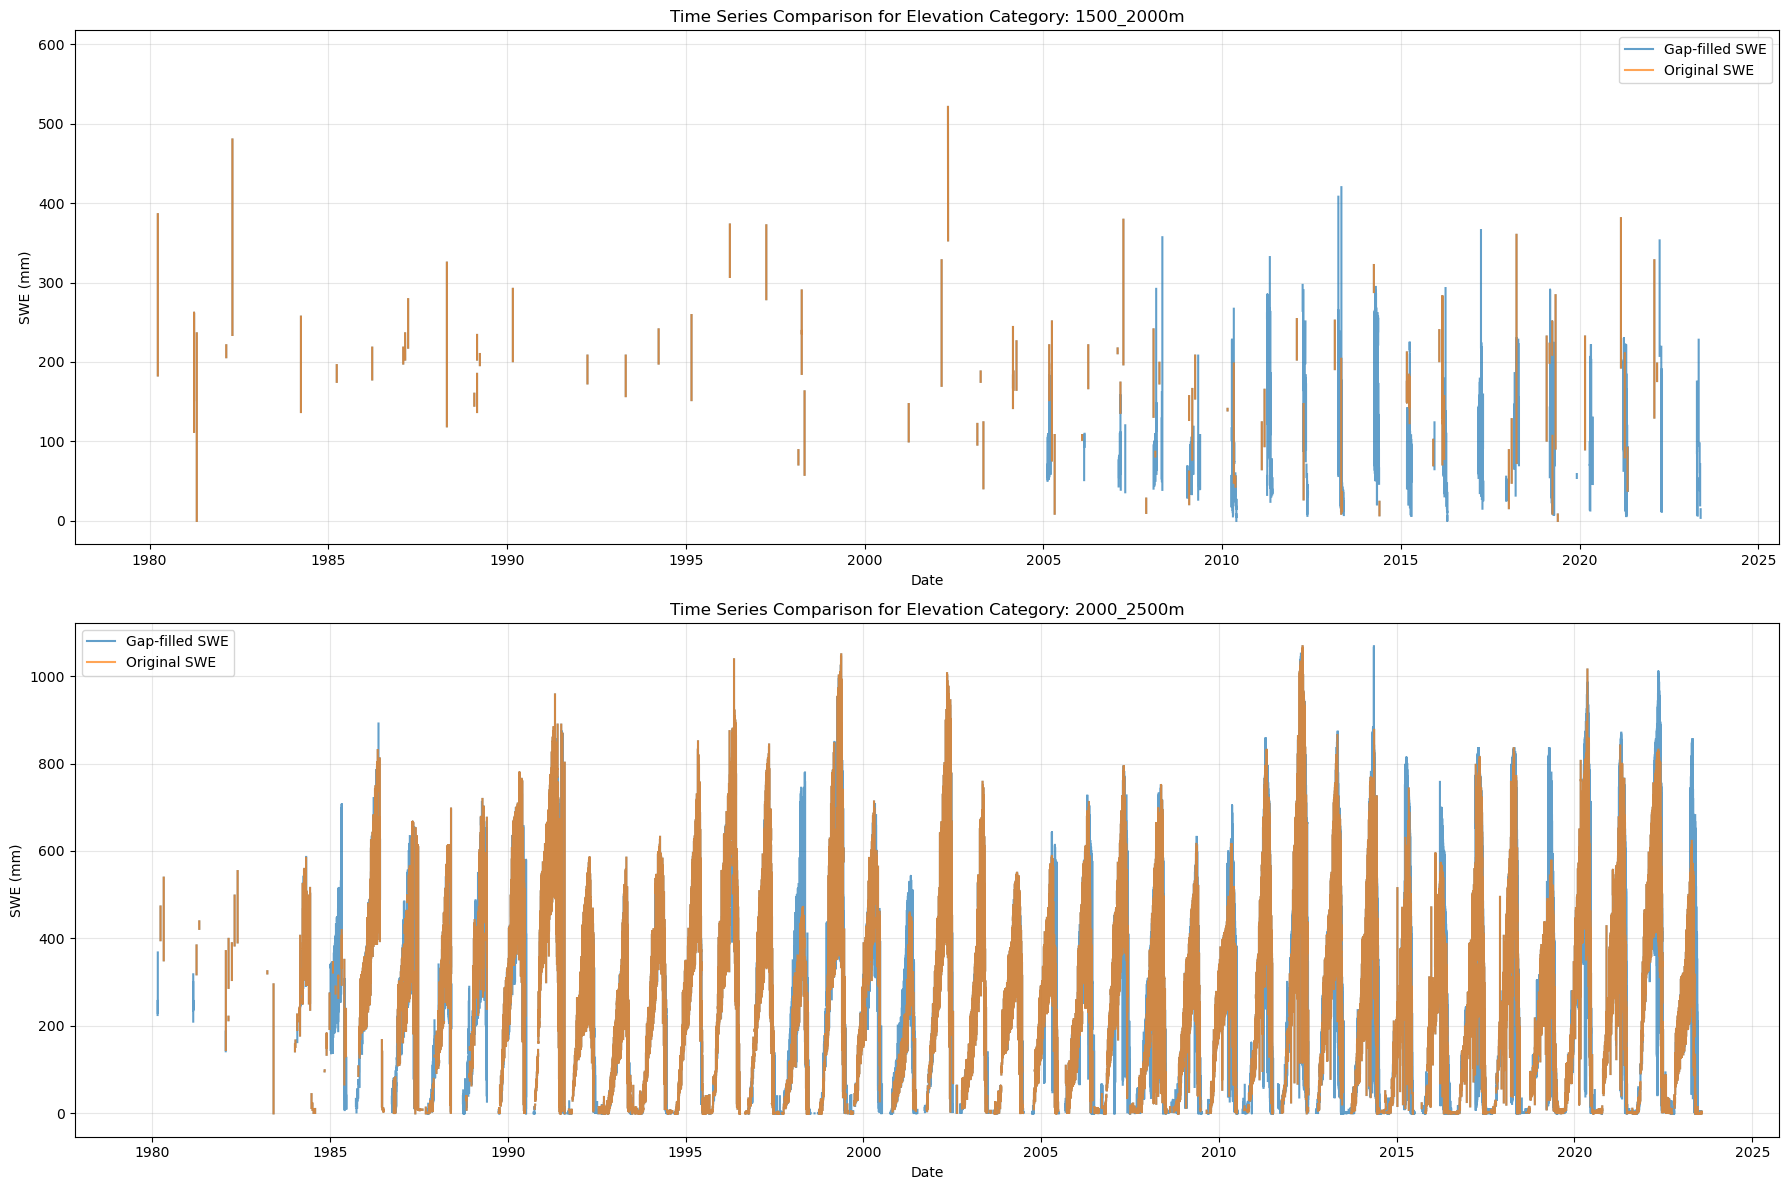

In [9]:
# Plot time series for each elevation category comparing Original_SWE and Gap_filled_SWE
elev_categories = [ '1500_2000m', '2000_2500m']

plt.figure(figsize=(18, 12))
for i, elev_cat in enumerate(elev_categories, 1):
    plt.subplot(len(elev_categories), 1, i)

    # Filter data for the current elevation category and sort by time
    df_cat = combined_canswe.loc[combined_canswe['Elevation_Category'] == elev_cat].sort_values('time')

    # Plot Gap-filled SWE (x and y have matching lengths)
    plt.plot(
        df_cat['time'],
        df_cat['Gap_Filled_CanSWE'],
        label='Gap-filled SWE',
        color='tab:blue',
        alpha=0.7
    )

    # Plot Original SWE (x and y have matching lengths)
    plt.plot(
        df_cat['time'],
        df_cat['Original_CanSWE'],
        label='Original SWE',
        color='tab:orange',
        alpha=0.7
    )

    plt.title(f'Time Series Comparison for Elevation Category: {elev_cat}')
    plt.xlabel('Date')
    plt.ylabel('SWE (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate SWEI